In [ ]:
import pandas as pd
import numpy as np
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

# Configurações de exibição e gráficos
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


In [ ]:

# --- 1. FUNÇÕES AUXILIARES DE AVALIAÇÃO E PRÉ-CÁLCULO ---

def get_top_n(predictions, n=10):
    """Mapeia as previsões para cada usuário e retorna as n melhores recomendações."""
    top_n = defaultdict(list)
    for uid, iid, _, est, _ in predictions:
        top_n[uid].append((iid, est))

    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    # Converte para um dicionário padrão para facilitar o uso
    return dict(top_n)

def calculate_item_popularity(data):
    """Calcula a popularidade dos itens (número de avaliações) e normaliza."""
    # Converter o objeto 'data' para um DataFrame pandas
    raw_ratings = data.raw_ratings
    df_ratings = pd.DataFrame(raw_ratings, columns=['user', 'item', 'rating', 'timestamp'])

    # Contar o número de avaliações por item
    popularity = df_ratings['item'].value_counts()

    # Criar um dicionário para mapeamento rápido item_id -> popularidade
    item_popularity = dict(zip(popularity.index, popularity.values))

    # Normalizar a popularidade para o intervalo [0, 1]
    if item_popularity:
        max_pop = max(item_popularity.values())
        normalized_popularity = {item: count / max_pop for item, count in item_popularity.items()}
    else:
        normalized_popularity = {}

    return normalized_popularity, len(df_ratings['item'].unique())

def calculate_diversity(top_n_recommendations, all_items_count):
    """
    Calcula o Item Coverage (em %) - número de itens únicos recomendados.
    """
    all_recommended_items = set()
    for _, items in top_n_recommendations.items():
        for iid, _ in items:
            all_recommended_items.add(iid)

    # Retorna o percentual de cobertura
    return (len(all_recommended_items) / all_items_count) * 100

def calculate_item_similarity(algo):
    """
    Calcula a matriz de similaridade de cosseno usando os fatores latentes (qi) dos itens do SVD.
    Retorna um dicionário de dicionários mapeado por IDs brutos (Raw IDs).
    """
    item_factors = algo.qi
    similarity_matrix = cosine_similarity(item_factors)

    trainset = algo.trainset
    n_items = trainset.n_items
    sim_dict = defaultdict(dict)

    for inner_i in range(n_items):
        raw_i = trainset.to_raw_iid(inner_i)

        for inner_j in range(inner_i, n_items):
            raw_j = trainset.to_raw_iid(inner_j)

            sim = similarity_matrix[inner_i, inner_j]

            sim_dict[raw_i][raw_j] = sim
            if raw_i != raw_j:
                sim_dict[raw_j][raw_i] = sim

    return dict(sim_dict)


In [ ]:

# --- 2. FUNÇÕES DE RE-RANKING ---

def rerank_by_popularity_penalty(predictions, item_popularity, alpha, k=10, testset=None):
    """
    Aplica re-ranking penalizando itens populares (anti-popularidade).
    """
    user_predictions = defaultdict(list)
    for uid, iid, _, est, _ in predictions:
        pop_normalized = item_popularity.get(iid, 0)

        # Penalidade: Adjusted_Score = Score_SVD - alpha * Popularity
        adjusted_score = est - alpha * pop_normalized

        user_predictions[uid].append((iid, adjusted_score, est))

    top_n_reranked = defaultdict(list)
    final_predictions_for_eval = []

    testset_ratings = {(uid, iid): r_ui for (uid, iid, r_ui) in testset}

    for uid, preds in user_predictions.items():
        # Ordenar pelo Score Ajustado
        preds.sort(key=lambda x: x[1], reverse=True)

        # Selecionar o Top-K (Mantém o score ORIGINAL para cálculo do RMSE)
        for iid, _, original_score in preds[:k]:
            top_n_reranked[uid].append((iid, original_score))

            # Recria a lista de predições com os ratings verdadeiros, APENAS para os itens selecionados
            r_ui = testset_ratings.get((uid, iid))
            if r_ui is not None:
                final_predictions_for_eval.append((uid, iid, r_ui, original_score, {}))

    return final_predictions_for_eval, dict(top_n_reranked)

def rerank_mmr(predictions, item_sim_matrix, testset_ratings, lambda_param, k=10):
    """
    Aplica o re-ranking usando Maximal Marginal Relevance (MMR).
    """

    user_preds = defaultdict(list)
    for uid, iid, _, est, _ in predictions:
        user_preds[uid].append({'item_id': iid, 'score': est}) # Score = Relevância

    reranked_results = defaultdict(list)
    final_predictions_for_eval = []

    for uid, candidate_list in user_preds.items():

        S = [] # Lista de itens selecionados
        R = list(candidate_list) # Conjunto de itens candidatos

        # Ordenar os candidatos inicialmente pela relevância (MMR começa pelo item mais relevante)
        R.sort(key=lambda x: x['score'], reverse=True)

        for _ in range(k):
            if not R:
                break

            best_mmr_score = -np.inf
            best_item_data = None

            for candidate in R:
                item_id = candidate['item_id']
                relevance = candidate['score'] # Relevância (R_i)

                # Termo de Diversidade: max(Sim(i, j))
                max_sim = 0
                if S:
                    similarities = [item_sim_matrix.get(item_id, {}).get(s_id, 0) for s_id, _ in S]
                    max_sim = max(similarities)

                # Cálculo do MMR: λ * Relevância - (1 - λ) * max_sim
                mmr_score = (lambda_param * relevance) - ((1 - lambda_param) * max_sim)

                if mmr_score > best_mmr_score:
                    best_mmr_score = mmr_score
                    best_item_data = candidate

            if best_item_data:
                # Adiciona a S e remove de R
                item_id = best_item_data['item_id']
                original_score = best_item_data['score']

                S.append((item_id, original_score))
                R = [item for item in R if item['item_id'] != item_id]

                # Prepara para avaliação RMSE
                r_ui = testset_ratings.get((uid, item_id))
                if r_ui is not None:
                    final_predictions_for_eval.append((uid, item_id, r_ui, original_score, {}))

        reranked_results[uid] = S

    return final_predictions_for_eval, dict(reranked_results)


In [ ]:


# --- 3. PRÉ-CÁLCULOS GERAIS (SVD, Popularidade, Sim. de Itens) ---

print("Iniciando a análise de Trade-off (Precisão vs. Diversidade)")

# 1. Carregar e Dividir os Dados
print("\n[1/4] Carregando e dividindo os dados (ml-100k)...")
data = Dataset.load_builtin('ml-100k')
trainset, testset = train_test_split(data, test_size=0.25, random_state=42)

# Mapear (user_id, item_id) para o rating verdadeiro (r_ui) do testset
testset_ratings = {(uid, iid): r_ui for (uid, iid, r_ui) in testset}

# 2. Calcular Popularidade
item_popularity, all_items_count = calculate_item_popularity(data)
print(f"Total de itens únicos: {all_items_count}")

# 3. Treinar o Modelo Baseline (SVD) - Necessário para ambos os re-rankings
print("[2/4] Treinando modelo SVD baseline (para ambos os métodos)...")
algo_baseline = SVD(random_state=42, n_epochs=20, n_factors=50)
algo_baseline.fit(trainset)

# 4. Gerar Previsões e Matriz de Similaridade - Necessário para ambos os re-rankings
print("[3/4] Gerando previsões e matriz de similaridade de itens...")
predictions_baseline = algo_baseline.test(testset)
item_sim_matrix = calculate_item_similarity(algo_baseline)


🎬 Iniciando a análise de Trade-off (Precisão vs. Diversidade)

[1/4] Carregando e dividindo os dados (ml-100k)...
Total de itens únicos: 1682
[2/4] Treinando modelo SVD baseline (para ambos os métodos)...
[3/4] Gerando previsões e matriz de similaridade de itens...


In [ ]:

# --- 4. ANÁLISE DO TRADE-OFF: PENALIZAÇÃO POR POPULARIDADE ---

def run_popularity_analysis(predictions_baseline, item_popularity, testset, all_items_count):
    print("\n--- ANÁLISE 1: Penalização por Popularidade (Alpha) ---")

    # Alphas: Fator de penalização (0 = baseline SVD, 1.0 = penalidade máxima)
    alphas = np.linspace(0.0, 1.0, 11)
    results = []

    for alpha in alphas:
        # Aplicar o Re-ranking
        reranked_preds_eval, top_n_reranked = rerank_by_popularity_penalty(
            predictions_baseline, item_popularity, alpha=alpha, k=10, testset=testset
        )

        # Avaliação de Precisão: RMSE
        rmse = accuracy.rmse(reranked_preds_eval, verbose=False)

        # Avaliação de Diversidade: Item Coverage (em %)
        coverage = calculate_diversity(top_n_reranked, all_items_count)

        results.append({
            'alpha': alpha,
            'rmse': rmse,
            'coverage': coverage
        })
        print(f"  Alpha={alpha:.1f}: RMSE={rmse:.4f}, Item Coverage={coverage:.2f}%")

    results_df = pd.DataFrame(results)

    # Visualização
    fig, ax1 = plt.subplots(figsize=(10, 6))

    color_rmse = 'tab:red'
    ax1.set_xlabel('Fator de Penalização (alpha)')
    ax1.set_ylabel('Precisão (RMSE - Menor é Melhor)', color=color_rmse)
    line1 = ax1.plot(results_df['alpha'], results_df['rmse'], color=color_rmse, marker='o', label='RMSE (Precisão)')
    ax1.tick_params(axis='y', labelcolor=color_rmse)
    ax1.invert_yaxis()

    ax2 = ax1.twinx()
    color_coverage = 'tab:blue'
    ax2.set_ylabel('Diversidade (Item Coverage % - Maior é Melhor)', color=color_coverage)
    line2 = ax2.plot(results_df['alpha'], results_df['coverage'], color=color_coverage, marker='x', label='Item Coverage (Diversidade)')
    ax2.tick_params(axis='y', labelcolor=color_coverage)

    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='lower right')

    fig.suptitle('Trade-off: Precisão vs. Diversidade (Penalização por Popularidade)', fontsize=14)
    plt.tight_layout()
    plt.show()

    return results_df



--- ANÁLISE 1: Penalização por Popularidade (Alpha) ---
  Alpha=0.0: RMSE=0.9082, Item Coverage=46.25%
  Alpha=0.1: RMSE=0.9073, Item Coverage=46.85%
  Alpha=0.2: RMSE=0.9061, Item Coverage=47.21%
  Alpha=0.3: RMSE=0.9060, Item Coverage=47.98%
  Alpha=0.4: RMSE=0.9066, Item Coverage=48.87%
  Alpha=0.5: RMSE=0.9078, Item Coverage=49.23%
  Alpha=0.6: RMSE=0.9115, Item Coverage=50.18%
  Alpha=0.7: RMSE=0.9113, Item Coverage=51.07%
  Alpha=0.8: RMSE=0.9099, Item Coverage=51.66%
  Alpha=0.9: RMSE=0.9121, Item Coverage=52.32%
  Alpha=1.0: RMSE=0.9129, Item Coverage=53.15%


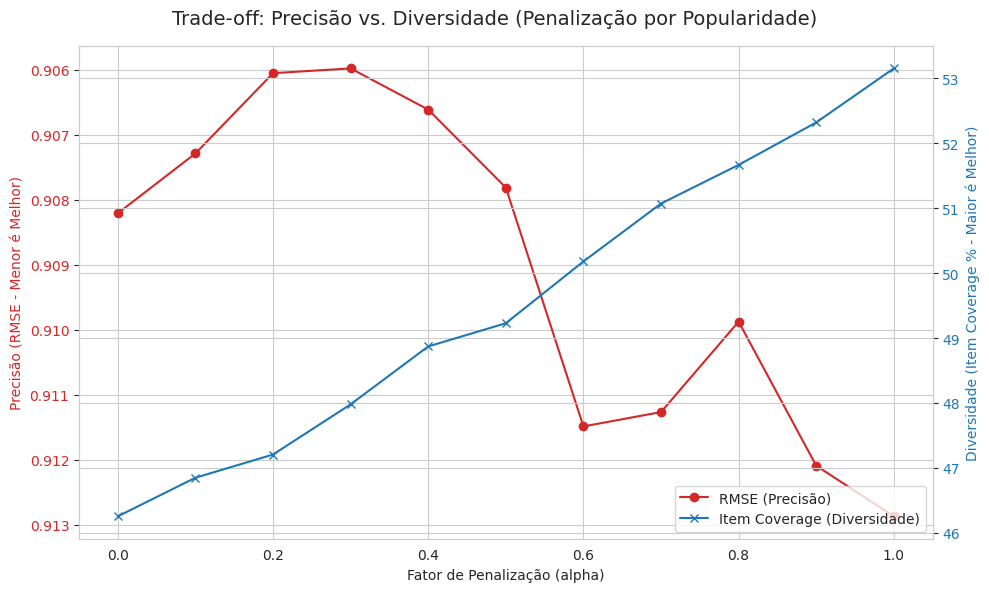


--- ANÁLISE 2: Maximal Marginal Relevance (MMR, Lambda) ---
  Lambda=0.0: RMSE=0.9538, Item Coverage=68.79%
  Lambda=0.1: RMSE=0.9356, Item Coverage=59.51%
  Lambda=0.2: RMSE=0.9249, Item Coverage=53.75%
  Lambda=0.3: RMSE=0.9197, Item Coverage=50.18%
  Lambda=0.4: RMSE=0.9169, Item Coverage=48.16%
  Lambda=0.5: RMSE=0.9122, Item Coverage=47.56%
  Lambda=0.6: RMSE=0.9101, Item Coverage=46.79%
  Lambda=0.7: RMSE=0.9073, Item Coverage=46.43%
  Lambda=0.8: RMSE=0.9065, Item Coverage=46.43%
  Lambda=0.9: RMSE=0.9066, Item Coverage=46.55%
  Lambda=1.0: RMSE=0.9082, Item Coverage=46.25%


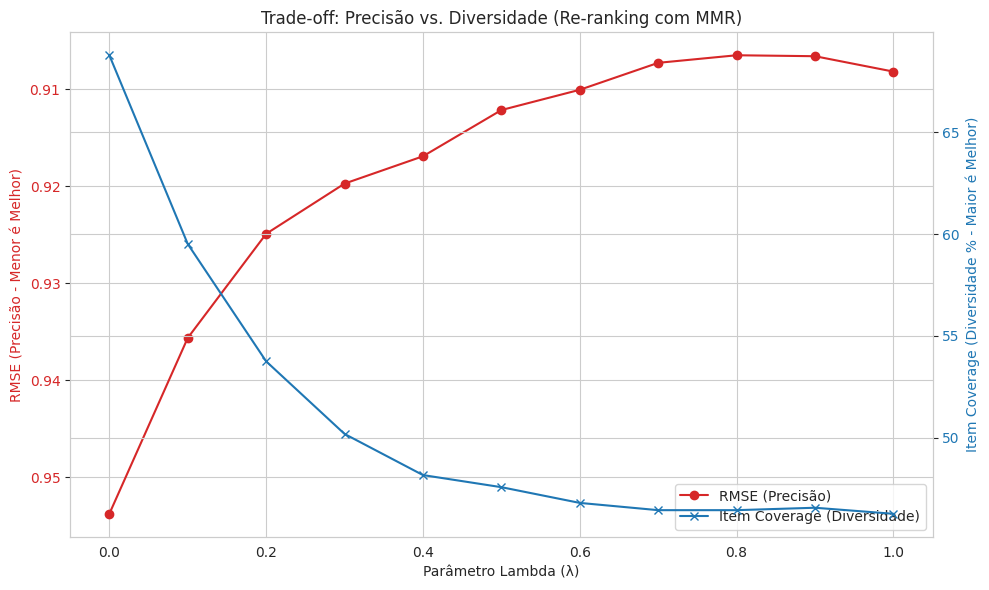


✅ Todas as análises concluídas e resultados armazenados em 'popularity_df' e 'mmr_df'.


In [ ]:

# --- 5. ANÁLISE DO TRADE-OFF: MMR (Maximal Marginal Relevance) ---

def run_mmr_analysis(predictions_baseline, item_sim_matrix, testset_ratings, all_items_count):
    print("\n--- ANÁLISE 2: Maximal Marginal Relevance (MMR, Lambda) ---")

    # Lambdas: (1.0 = Max Relevância/Baseline SVD | 0.0 = Max Diversidade)
    lambdas = np.linspace(0.0, 1.0, 11)
    mmr_results = []

    for lambda_param in lambdas:
        # Aplicar o Re-ranking com MMR
        reranked_preds_eval, top_n_mmr = rerank_mmr(
            predictions_baseline, item_sim_matrix, testset_ratings, lambda_param=lambda_param, k=10
        )

        # Avaliação de Precisão: RMSE
        rmse = accuracy.rmse(reranked_preds_eval, verbose=False)

        # Avaliação de Diversidade: Item Coverage (%)
        item_coverage = calculate_diversity(top_n_mmr, all_items_count)

        mmr_results.append({
            'lambda': lambda_param,
            'RMSE': rmse,
            'Item_Coverage': item_coverage
        })
        print(f"  Lambda={lambda_param:.1f}: RMSE={rmse:.4f}, Item Coverage={item_coverage:.2f}%")

    results_df = pd.DataFrame(mmr_results)

    # Visualização
    fig, ax1 = plt.subplots(figsize=(10, 6))

    color_rmse = 'tab:red'
    ax1.set_xlabel('Parâmetro Lambda (λ)')
    ax1.set_ylabel('RMSE (Precisão - Menor é Melhor)', color=color_rmse)
    line1 = ax1.plot(results_df['lambda'], results_df['RMSE'], color=color_rmse, marker='o', label='RMSE (Precisão)')
    ax1.tick_params(axis='y', labelcolor=color_rmse)
    ax1.invert_yaxis()

    ax2 = ax1.twinx()
    color_coverage = 'tab:blue'
    ax2.set_ylabel('Item Coverage (Diversidade % - Maior é Melhor)', color=color_coverage)
    line2 = ax2.plot(results_df['lambda'], results_df['Item_Coverage'], color=color_coverage, marker='x', label='Item Coverage (Diversidade)')
    ax2.tick_params(axis='y', labelcolor=color_coverage)

    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='lower right')

    plt.title('Trade-off: Precisão vs. Diversidade (Re-ranking com MMR)')
    plt.tight_layout()
    plt.show()

    return results_df

# --- EXECUÇÃO PRINCIPAL ---
if __name__ == "__main__":

    # Executa a Análise 1: Penalização por Popularidade
    popularity_df = run_popularity_analysis(predictions_baseline, item_popularity, testset, all_items_count)

    # Executa a Análise 2: MMR
    mmr_df = run_mmr_analysis(predictions_baseline, item_sim_matrix, testset_ratings, all_items_count)

    print("\n✅ Todas as análises concluídas e resultados armazenados em 'popularity_df' e 'mmr_df'.")